## Correlation

### 1. Anomalies and Boundary Points

In [1]:
from orix import io
from process_indexing_data import compute_roi_misorientation_map_from_xmap, extract_roi_quaternions, match_data_by_coords, analyze_quaternion_scores_relationship, analyze_quaternion_variations_relationship, plot_phase_heatmap
import kikuchipy as kp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_eds_average, coord_xmap_dict, get_components, add_gaussian_noise_to_kikuchi_patterns
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum, detect_anomalies_cnmf, plot_weight_map_cnmf_with_anomalies, plot_weight_map_cnmf
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca, plot_explained_variance
from cluster_analysis import gmm_clustering, calculate_cluster_metrics, plot_cnmf_scatter_with_boundary, plot_cluster_distances_ranking, find_best_reference_window, plot_cluster_heatmap, evaluate_clustering_metrics, plot_intra_cluster_variation_map, compute_mahalanobis_to_reference

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


x dimensions 62 
 y dimensions 41 
 in multiples of 1


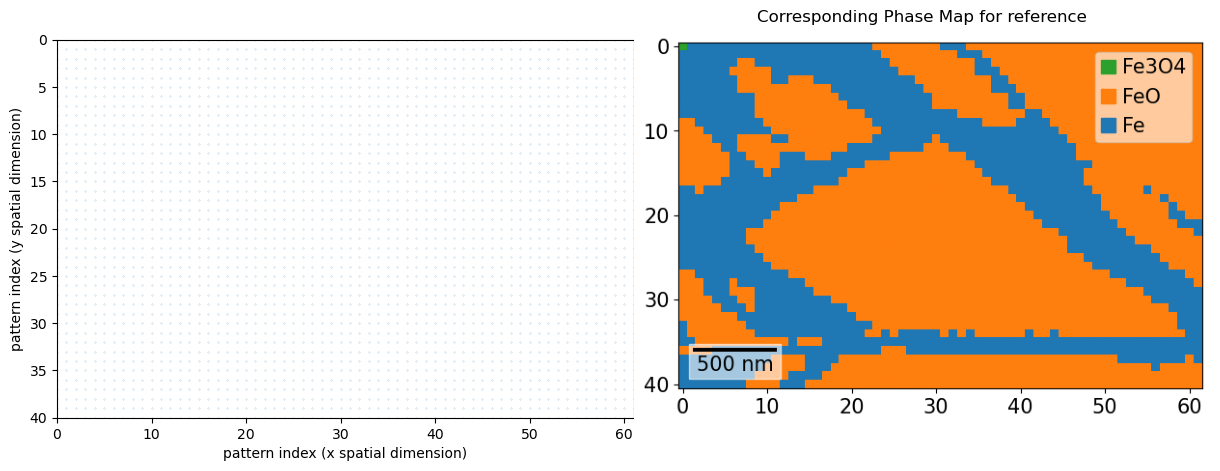

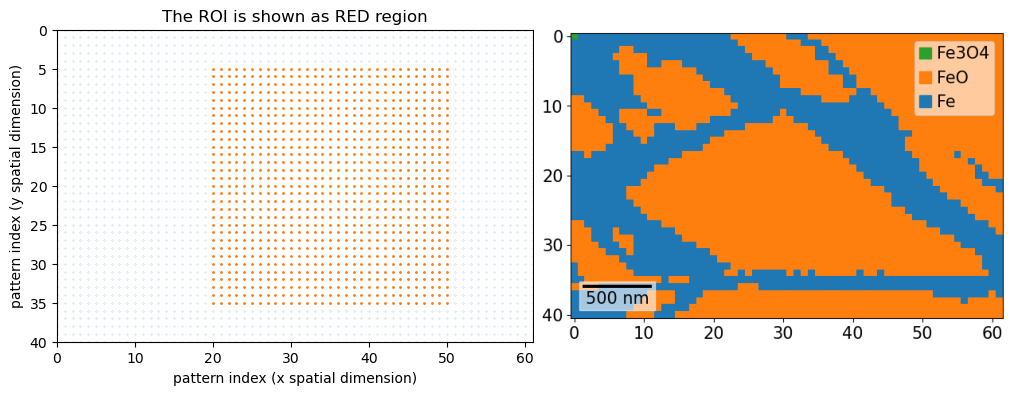

In [2]:
data_path = "../EBSD_scan"

fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)

edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)


xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229

xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

s_edax.xmap = xmap
s_edax.xmap.phases

path = "../EBSD_scan/"
grid = read_data(path)

# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)
loc = np.array(loc)
# dict {x,y} coordinates: phase index (all included)
coor_dict = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)

[                                        ] | 0% Completed | 1.65 ms

[########################################] | 100% Completed | 111.58 ms
[########################################] | 100% Completed | 110.77 ms
[########################################] | 100% Completed | 117.51 ms
[########################################] | 100% Completed | 114.85 ms
[########################################] | 100% Completed | 108.62 ms
[########################################] | 100% Completed | 113.18 ms
[########################################] | 100% Completed | 109.04 ms
[########################################] | 100% Completed | 122.09 ms
[########################################] | 100% Completed | 111.59 ms
[########################################] | 100% Completed | 126.83 ms
[########################################] | 100% Completed | 107.14 ms
[########################################] | 100% Completed | 110.94 ms
[########################################] | 100% Completed | 112.48 ms
[########################################] | 100% Completed | 11

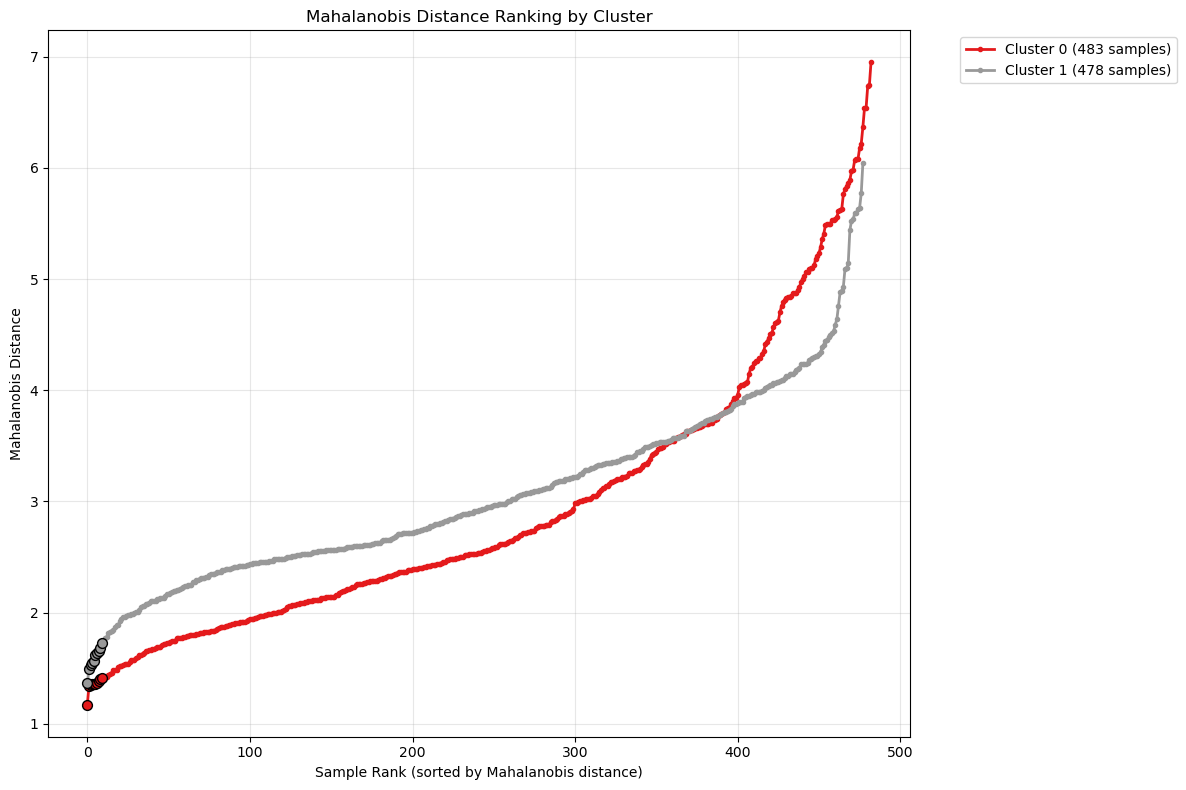

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.1717 - 1.4073
  Coordinates: [[29 27]
 [33 25]
 [24 25]]...

Cluster 1: 10 samples
  Distance range: 1.3618 - 1.7285
  Coordinates: [[32 12]
 [41 16]
 [48 16]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [29 27]
  Metric Value: 1.7666 (w1=1, w2=1)
  Window Mean Distance: 1.6862
  Window Variance: 0.0804
----------------------------------------
Cluster 1:
  Center Location: [41 16]
  Metric Value: 1.9042 (w1=1, w2=1)
  Window Mean Distance: 1.8374
  Window Variance: 0.0667
----------------------------------------


In [19]:
# weights for each component
pca_scores1, pca = run_PCA(R6, 10)
df = pd.DataFrame(pca_scores1)
df.to_csv("pca_scores1.csv", index=False)

gmm_model2, cluster_coords_c2, cluster_labels2, optimal_n, silhouette = gmm_clustering(pca_scores1,loc, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label2 = {}
for label, coords_list in cluster_coords_c2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label2[coord_tuple] = label
anomalies_cluster_pca_scores2, anomalies_cluster_pca_coords2, anomalies_labels_pca2 = detect_anomalies_pca(pca_scores1, coord_to_label2, loc)
anomalies_coord_label_dict2 = {}
for i in range(len(anomalies_labels_pca2)):
    coord = tuple(anomalies_cluster_pca_coords2[i])
    anomalies_coord_label_dict2[coord] = anomalies_labels_pca2[i]
centers2, covs2, variations2 = calculate_cluster_metrics(gmm_model2, cluster_labels2, pca_scores1)

top_samples_per_cluster2= plot_cluster_distances_ranking(gmm_model2, cluster_labels2, pca_scores1, loc)
best_window2 = find_best_reference_window(top_samples_per_cluster2, cluster_labels2, variations2, loc)

The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 110.49 ms
[########################################] | 100% Completed | 110.37 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 106.96 ms
[########################################] | 100% Completed | 109.33 ms
[########################################] | 100% Completed | 112.31 ms
[########################################] | 100% Completed | 110.51 ms
[########################################] | 100% Completed | 112.37 ms
[########################################] | 100% Completed | 112.39 ms
[########################################] | 100% Completed | 118.92 ms
[########################################] | 100% Completed | 120.20 ms
[########################################] | 100% Completed | 120.36 ms
[########################################] | 100% Completed | 120.40 ms
[########################################] | 100% Completed 

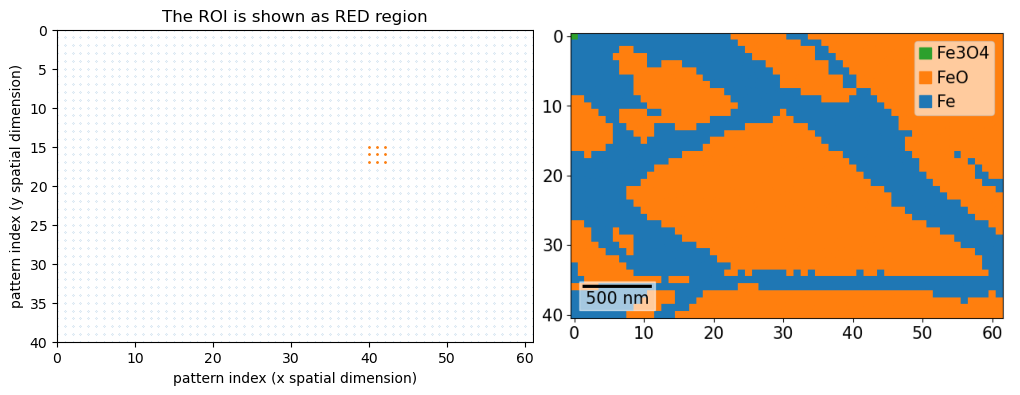

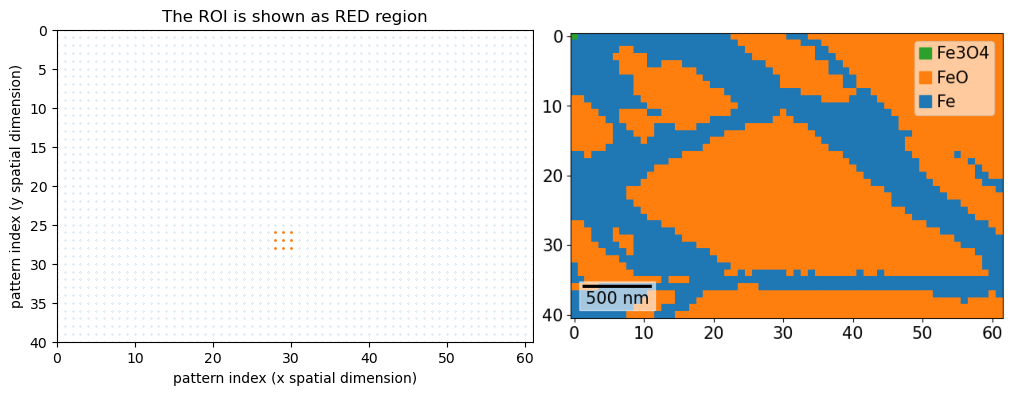

In [4]:
# set components
x_range_7 = (40,42)
y_range_7 = (15,17)
R7, ref7_pos = set_component(x_range_7, y_range_7, path, grid)


x_range_8 = (28,30)
y_range_8 = (26,28)
R8, ref8_pos = set_component(x_range_8, y_range_8, path, grid)


components = get_components(R7, R8)

# run cNMF
weights1,mse,r_square = run_cNMF(R6, components)
df = pd.DataFrame(weights1)
df.to_csv("weight1.csv", index=False)


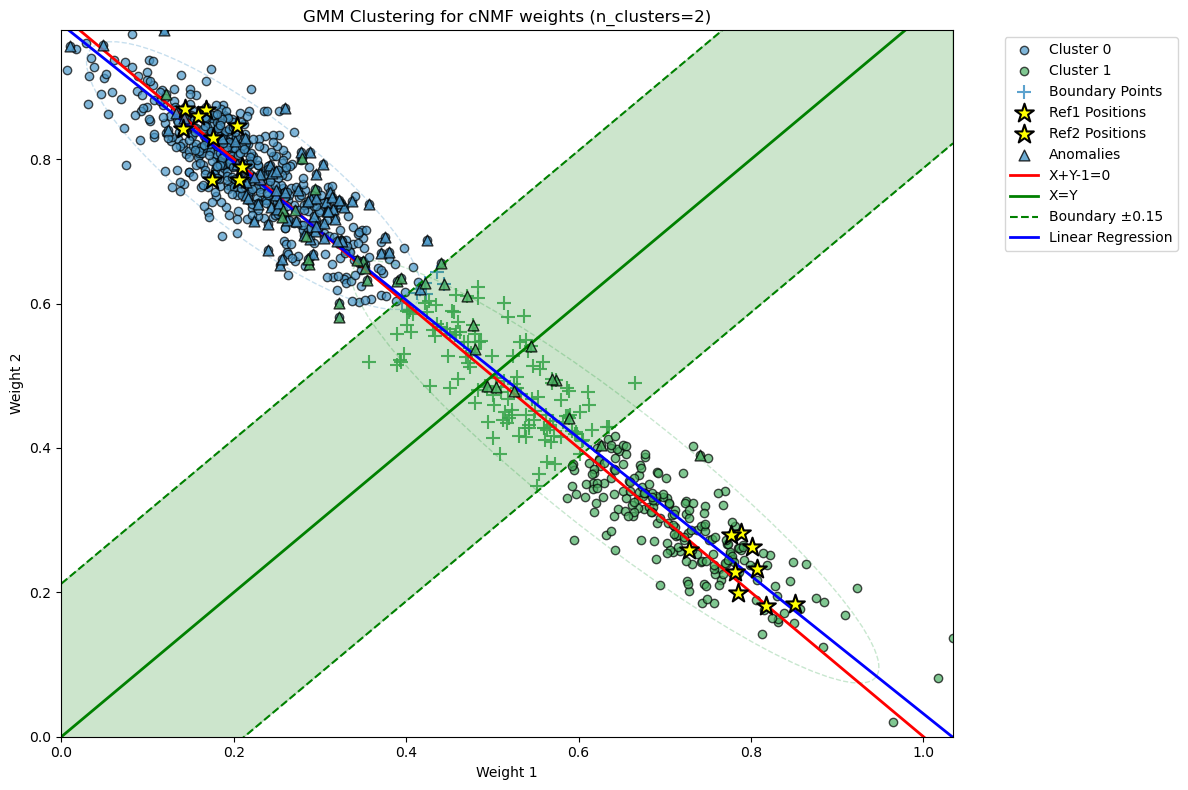

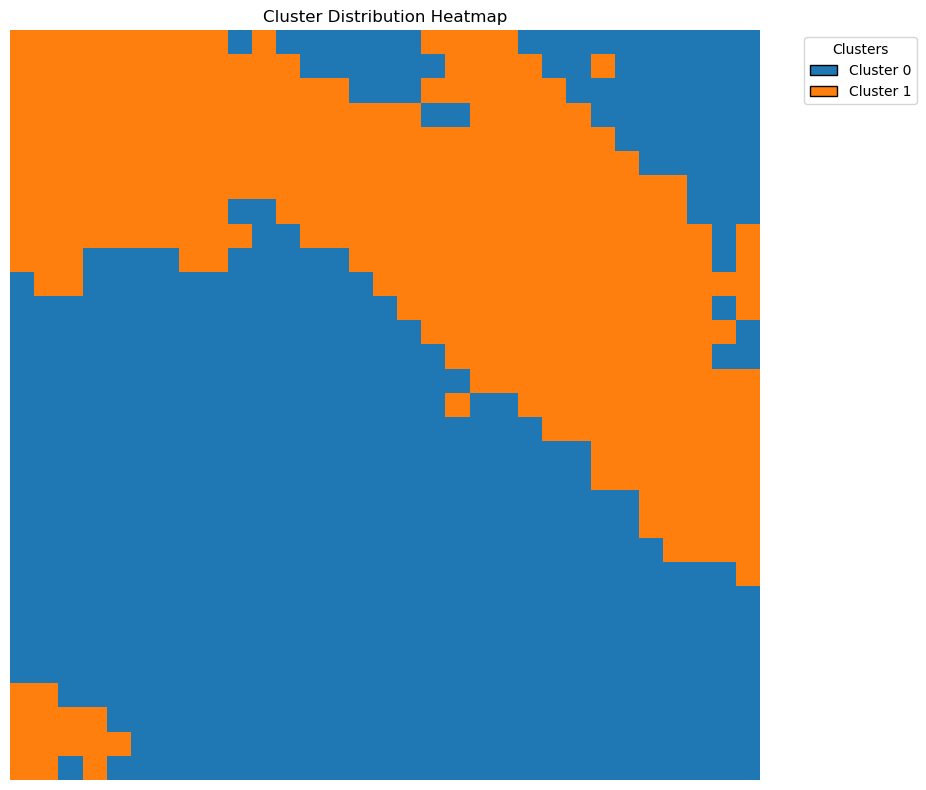

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.527554
             NMI 0.411417
     homogeneity 0.423353
    completeness 0.400136
       v_measure 0.411417
   user_accuracy 0.864724
optimal_accuracy 0.864724

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      603          FeO               FeO
       1      358           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        565        92
True: Fe          38       266


In [5]:
# gmm clustering for cNMF weights
gmm_model8, cluster_coords_cnmf8, cluster_labels_cnmf8, optimal_n, silhouette = gmm_clustering(weights1, loc, None, 10)

boundary_mask, boundary_scores, boundary_locs, boundary_labels, slope, intercept = plot_cnmf_scatter_with_boundary(weights1, loc, cluster_labels_cnmf8, optimal_n, ref7_pos, ref8_pos, anomalies_coord_label_dict2, d=0.15)

coord_to_label_cnmf8 = {}
for label, coords_list in cluster_coords_cnmf8.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf8[coord_tuple] = label
boundary_coord_label_dict = {}
for i in range(len(boundary_labels)):
    coord = tuple(boundary_locs[i])
    boundary_coord_label_dict[coord] = boundary_labels[i]
    
plot_cluster_heatmap(cluster_coords_cnmf8,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label_cnmf8, name_map, cluster_name_map, True)

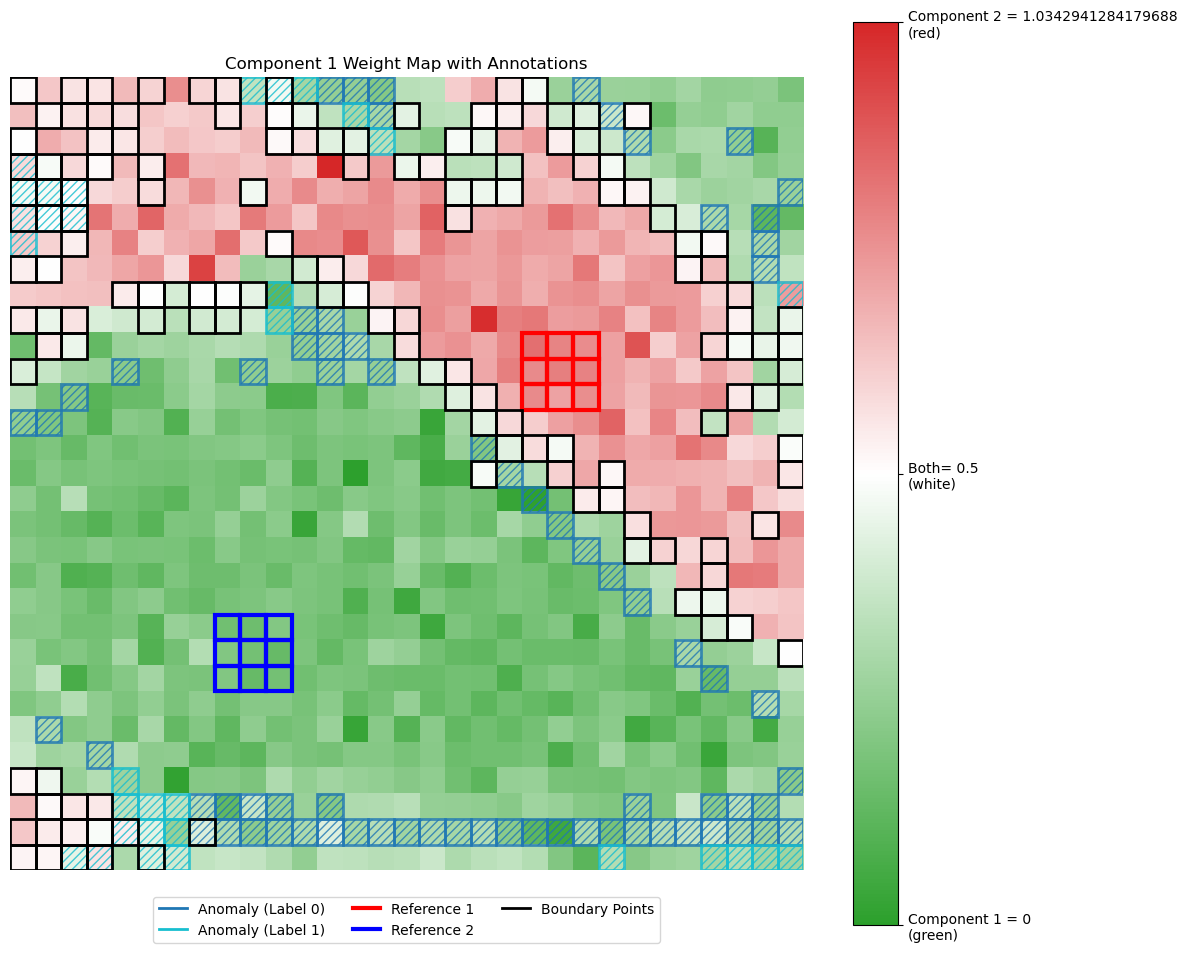

Similarity between anomalies and boundary points:
  Number of anomalies: 103
  Number of boundary points: 143
  Intersection: 13
  Jaccard Index: 0.0558
  Overlap Coefficient: 0.1262


In [6]:
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights1, loc, anomalies_coord_label_dict2, ref7_pos, ref8_pos, 0, boundary_locs)

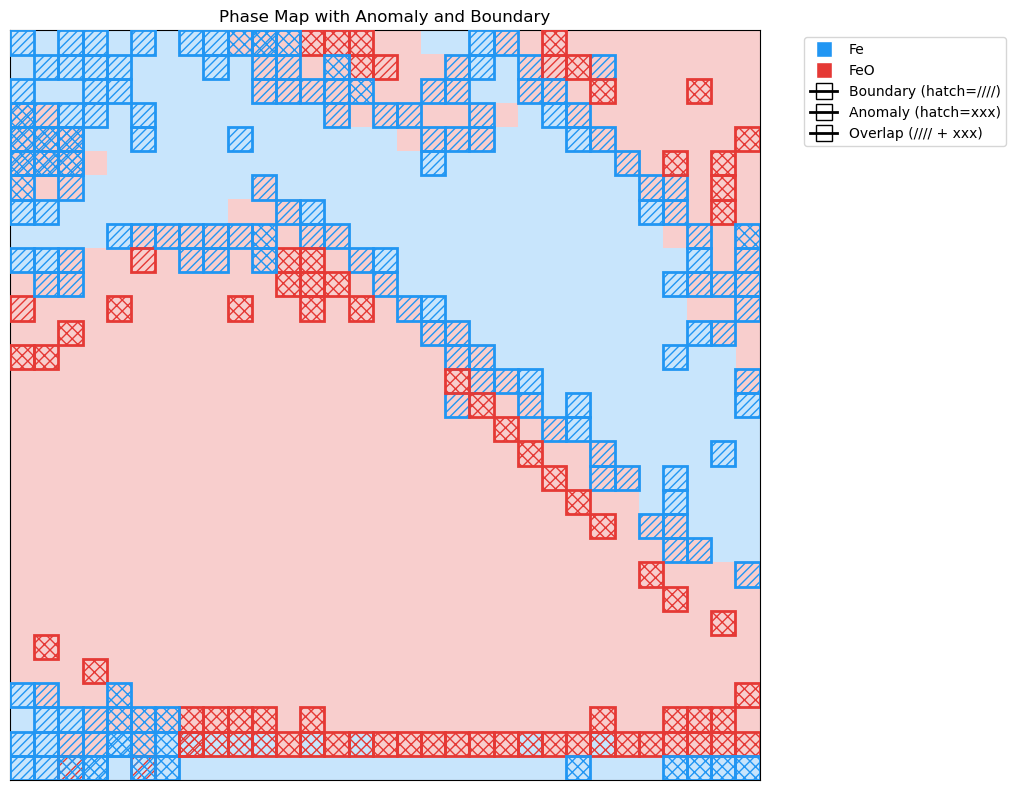

In [7]:
coor_phase_map= {2: 'FeO', 3:'Fe'}
boundary_loc_label_map={0: 'FeO', 1:'Fe'}
anomalies_loc_label_map={0: 'FeO', 1:'Fe'}
plot_phase_heatmap(coor_dict, boundary_coord_label_dict, anomalies_coord_label_dict2, coor_phase_map, boundary_loc_label_map, anomalies_loc_label_map, (31,31))

* > jaccard = len(set(A) & set(B)) / len(set(A) | set(B))
* > overlap = len(set(A) & set(B)) / min(len(set(A)), len(set(B)))

### 1.2 Artificial Noise (Gaussian noise)

In [3]:
noisy_images_array, output_paths= add_gaussian_noise_to_kikuchi_patterns(R6, 25, "./Noise_scan", True)

Processing 961 Kikuchi patterns...
Adding Gaussian noise with std=25 (only within circular signal region)
Output folder: ./Noise_scan


Adding noise: 100%|██████████| 961/961 [00:05<00:00, 174.50it/s]



Completed processing!
Generated 961 noisy images
Output shape: (961, 239, 239, 3)
Saved to: ./Noise_scan


x dimensions 62 
 y dimensions 41 
 in multiples of 1


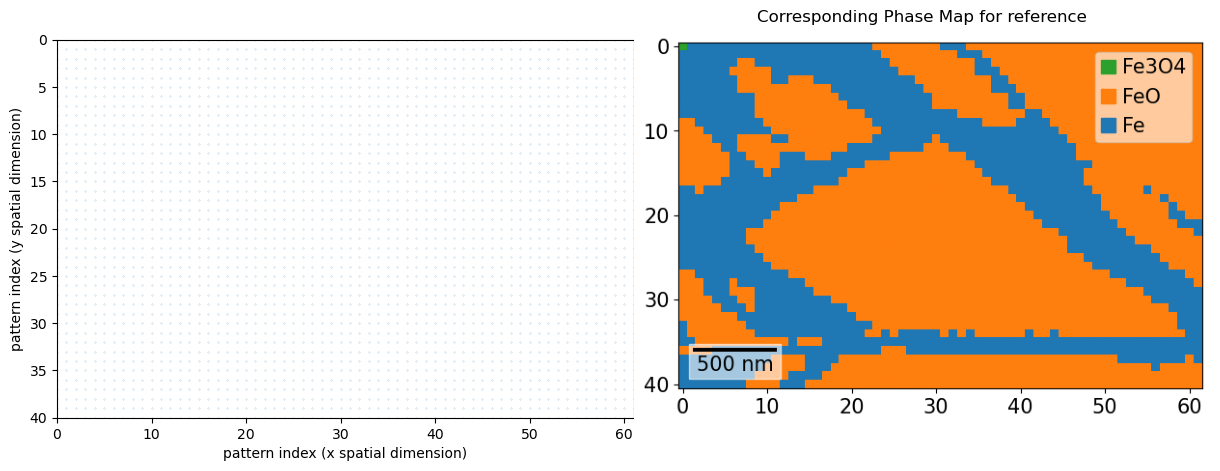

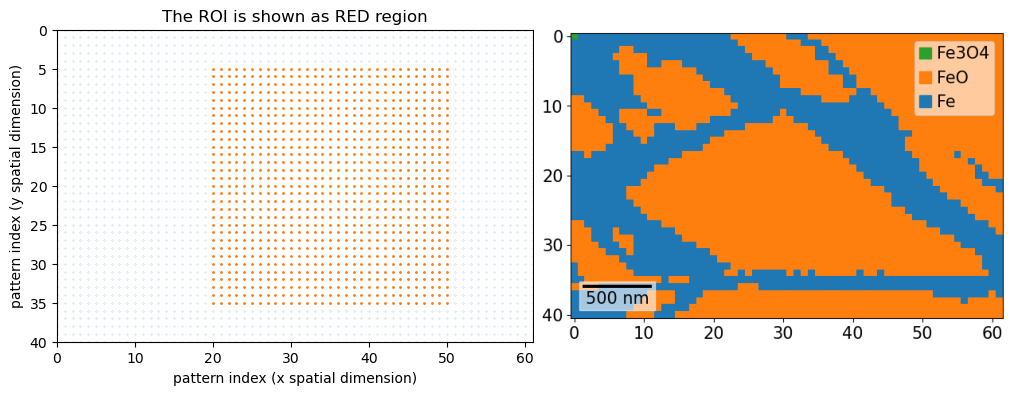

In [12]:
path = "./Noise_scan/"
grid = read_data(path)

# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R11, loc_n = set_ROI((20,50),(5,35), path, grid)
loc_n = np.array(loc_n)

[                                        ] | 0% Completed | 1.30 ms

[########################################] | 100% Completed | 110.44 ms
[########################################] | 100% Completed | 117.47 ms
[########################################] | 100% Completed | 110.19 ms
[########################################] | 100% Completed | 120.48 ms
[########################################] | 100% Completed | 115.53 ms
[########################################] | 100% Completed | 114.04 ms
[########################################] | 100% Completed | 108.31 ms
[########################################] | 100% Completed | 108.32 ms
[########################################] | 100% Completed | 112.51 ms
[########################################] | 100% Completed | 110.79 ms
[########################################] | 100% Completed | 110.88 ms
[########################################] | 100% Completed | 114.57 ms
[########################################] | 100% Completed | 119.56 ms
[########################################] | 100% Completed | 11

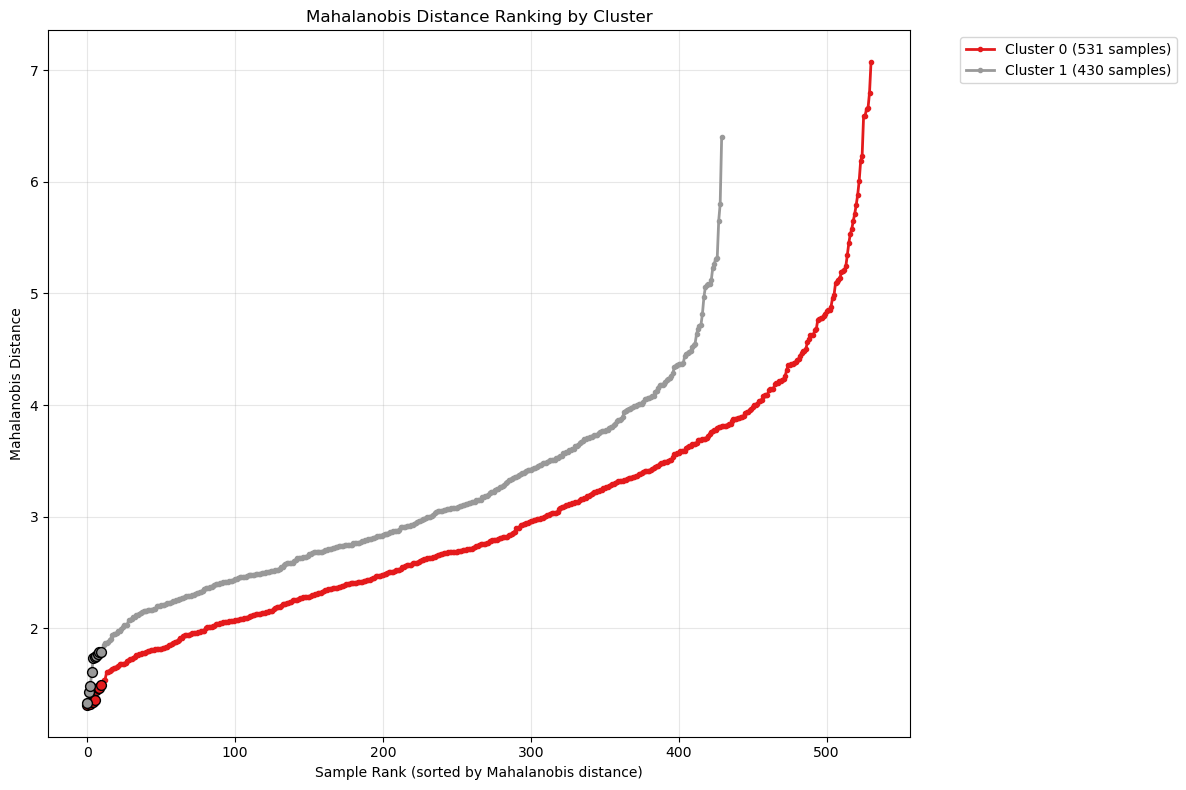

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.3164 - 1.4964
  Coordinates: [[41 31]
 [36 21]
 [28 16]]...

Cluster 1: 10 samples
  Distance range: 1.3269 - 1.7878
  Coordinates: [[41 16]
 [48 14]
 [41 17]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [22 24]
  Metric Value: 2.3268 (w1=1, w2=1)
  Window Mean Distance: 2.0961
  Window Variance: 0.2307
----------------------------------------
Cluster 1:
  Center Location: [41 17]
  Metric Value: 2.1748 (w1=1, w2=1)
  Window Mean Distance: 1.9810
  Window Variance: 0.1938
----------------------------------------


In [10]:
# weights for each component
pca_scores, pca = run_PCA(R11, 10)

gmm_model3, cluster_coords_c3, cluster_labels3, optimal_n, silhouette = gmm_clustering(pca_scores,loc_n, 2, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label3 = {}
for label, coords_list in cluster_coords_c3.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label3[coord_tuple] = label
anomalies_cluster_pca_scores3, anomalies_cluster_pca_coords3, anomalies_labels_pca3 = detect_anomalies_pca(pca_scores, coord_to_label3, loc_n)
anomalies_coord_label_dict3 = {}
for i in range(len(anomalies_labels_pca3)):
    coord = tuple(anomalies_cluster_pca_coords3[i])
    anomalies_coord_label_dict3[coord] = anomalies_labels_pca3[i]
centers3, covs3, variations3 = calculate_cluster_metrics(gmm_model3, cluster_labels3, pca_scores)


top_samples_per_cluster3= plot_cluster_distances_ranking(gmm_model3, cluster_labels3, pca_scores, loc_n)
best_window3 = find_best_reference_window(top_samples_per_cluster3, cluster_labels3, variations3, loc_n)

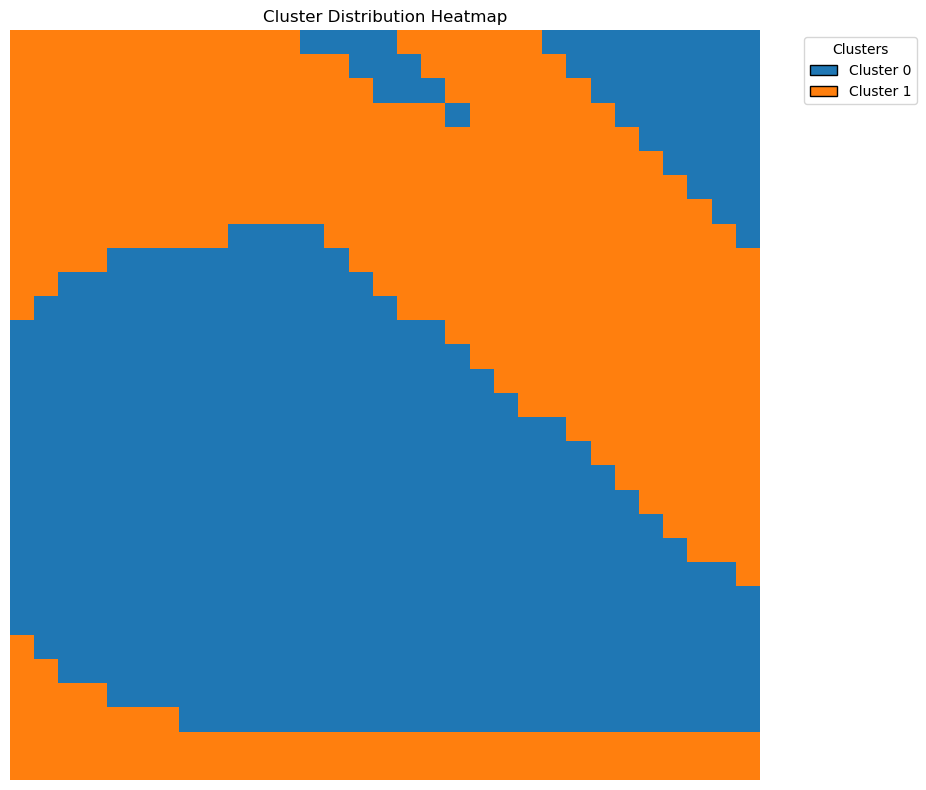

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.543221
             NMI 0.538912
     homogeneity 0.566345
    completeness 0.514014
       v_measure 0.538912
   user_accuracy 0.868887
optimal_accuracy 0.868887

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      531          FeO               FeO
       1      430           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        531       126
True: Fe           0       304
Cluster centers and corresponding labels: [(41, 31, 0), (41, 16, 1)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:620: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


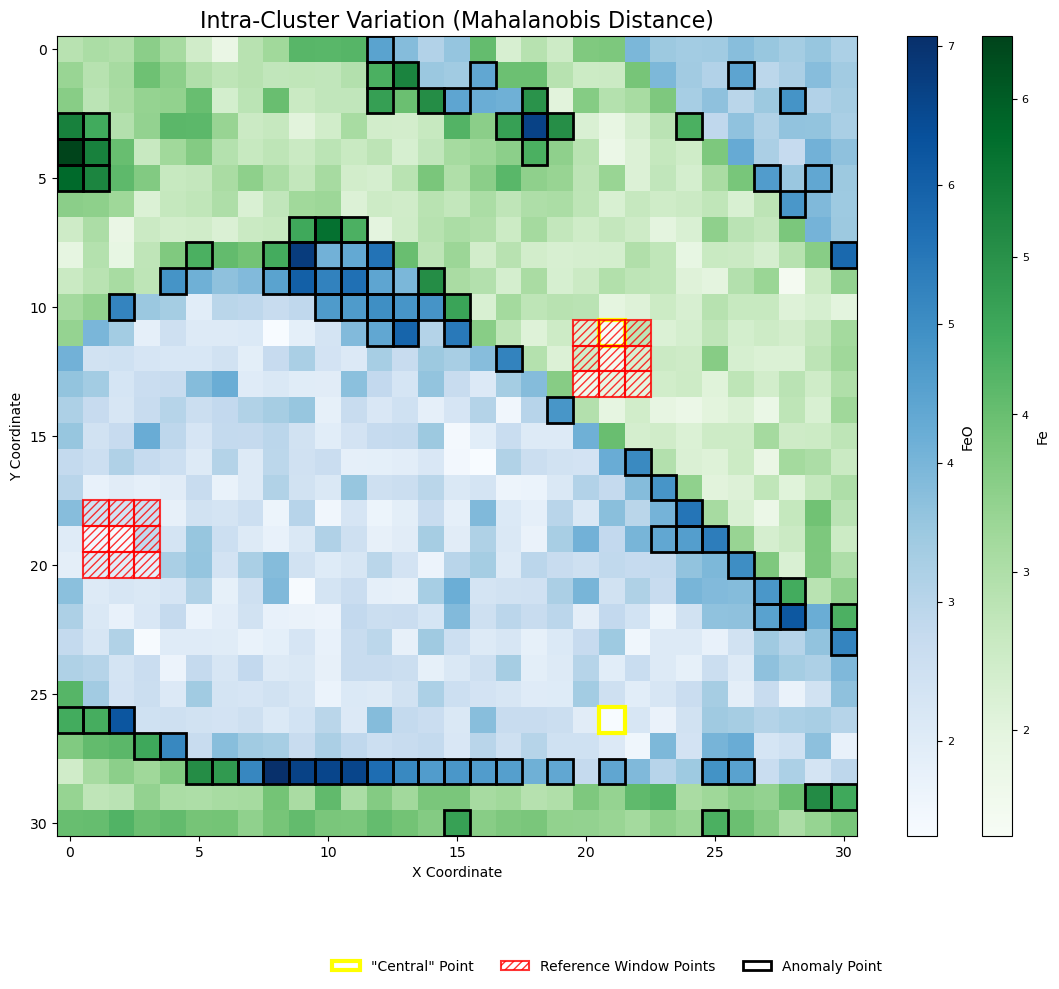

In [14]:
plot_cluster_heatmap(cluster_coords_c3,(31,31))
cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}


evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label3, name_map, cluster_name_map, True)

plot_intra_cluster_variation_map(loc_n, variations3, cluster_labels3, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords3, None, None, best_window3)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 1.78 ms

[########################################] | 100% Completed | 128.32 ms
[########################################] | 100% Completed | 107.08 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 112.13 ms
[########################################] | 100% Completed | 115.78 ms
[########################################] | 100% Completed | 107.92 ms
[########################################] | 100% Completed | 115.97 ms
[########################################] | 100% Completed | 109.92 ms
[########################################] | 100% Completed | 107.13 ms
[########################################] | 100% Completed | 116.62 ms
[########################################] | 100% Completed | 108.92 ms
[########################################] | 100% Completed | 105.92 ms
[########################################] | 100% Completed | 109.50 ms
[########################################] | 100% Completed | 107.95 ms
[#########################

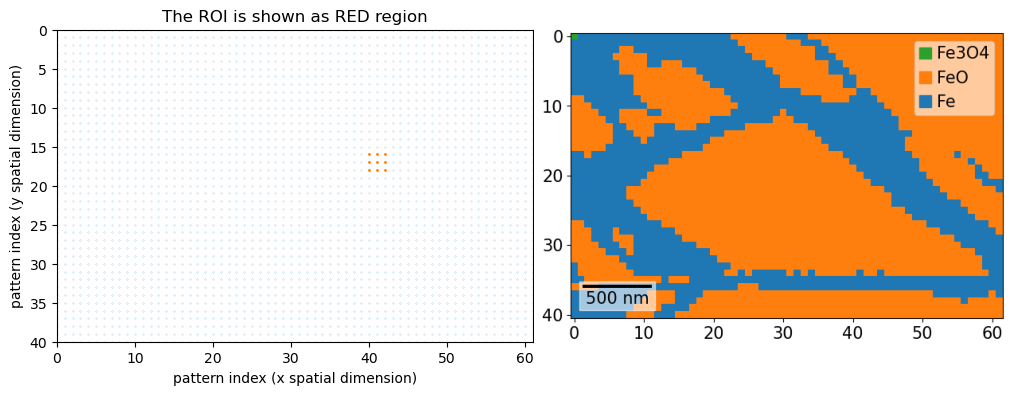

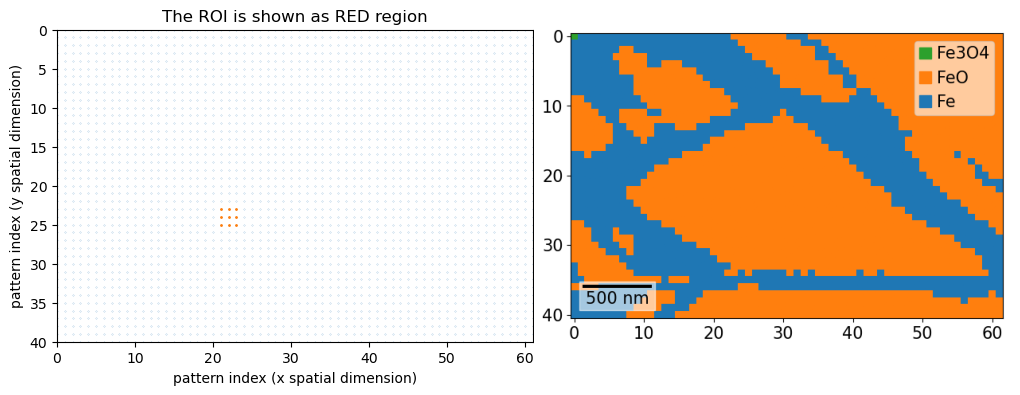

In [16]:
# set components
x_range_9 = (40,42)
y_range_9 = (16,18)
R9, ref9_pos = set_component(x_range_9, y_range_9, path, grid)


x_range_10 = (21,23)
y_range_10 = (23,25)
R10, ref10_pos = set_component(x_range_10, y_range_10, path, grid)

components = get_components(R9, R10)

# run cNMF
weights,mse,r_square = run_cNMF(R11, components)


Optimal clustering number: 2, silhouette: 0.607


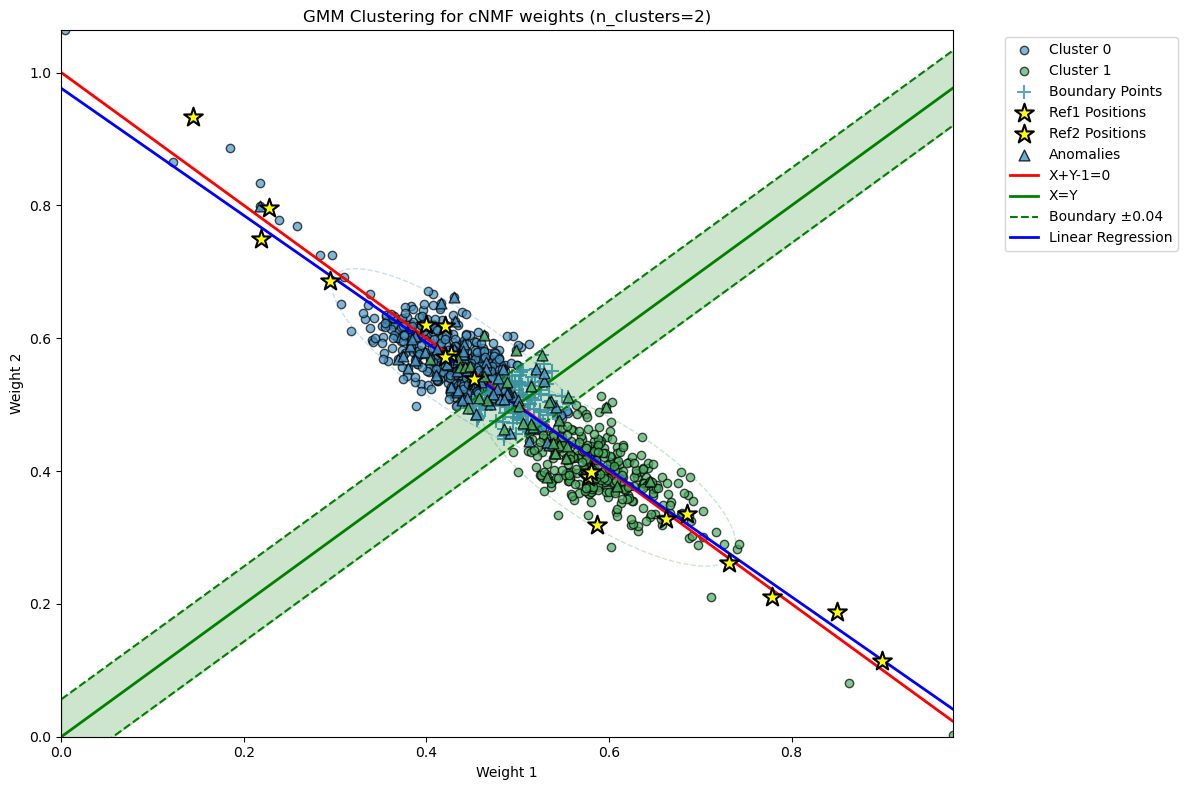

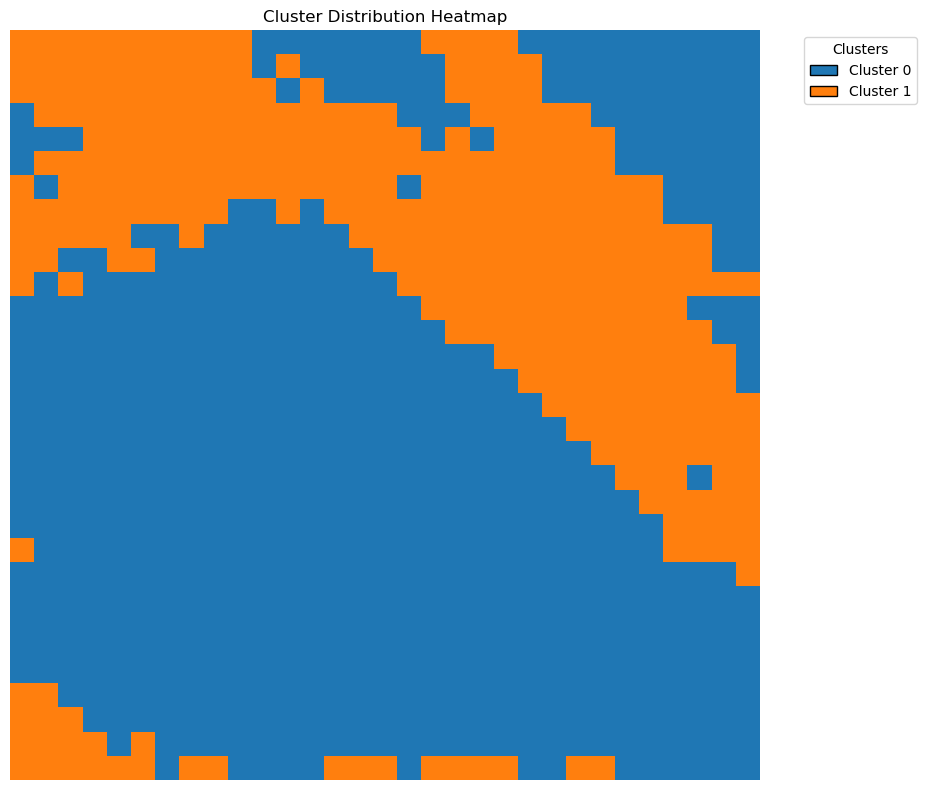

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.704316
             NMI 0.576137
     homogeneity 0.583728
    completeness 0.568740
       v_measure 0.576137
   user_accuracy 0.920916
optimal_accuracy 0.920916

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      635          FeO               FeO
       1      326           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        608        49
True: Fe          27       277


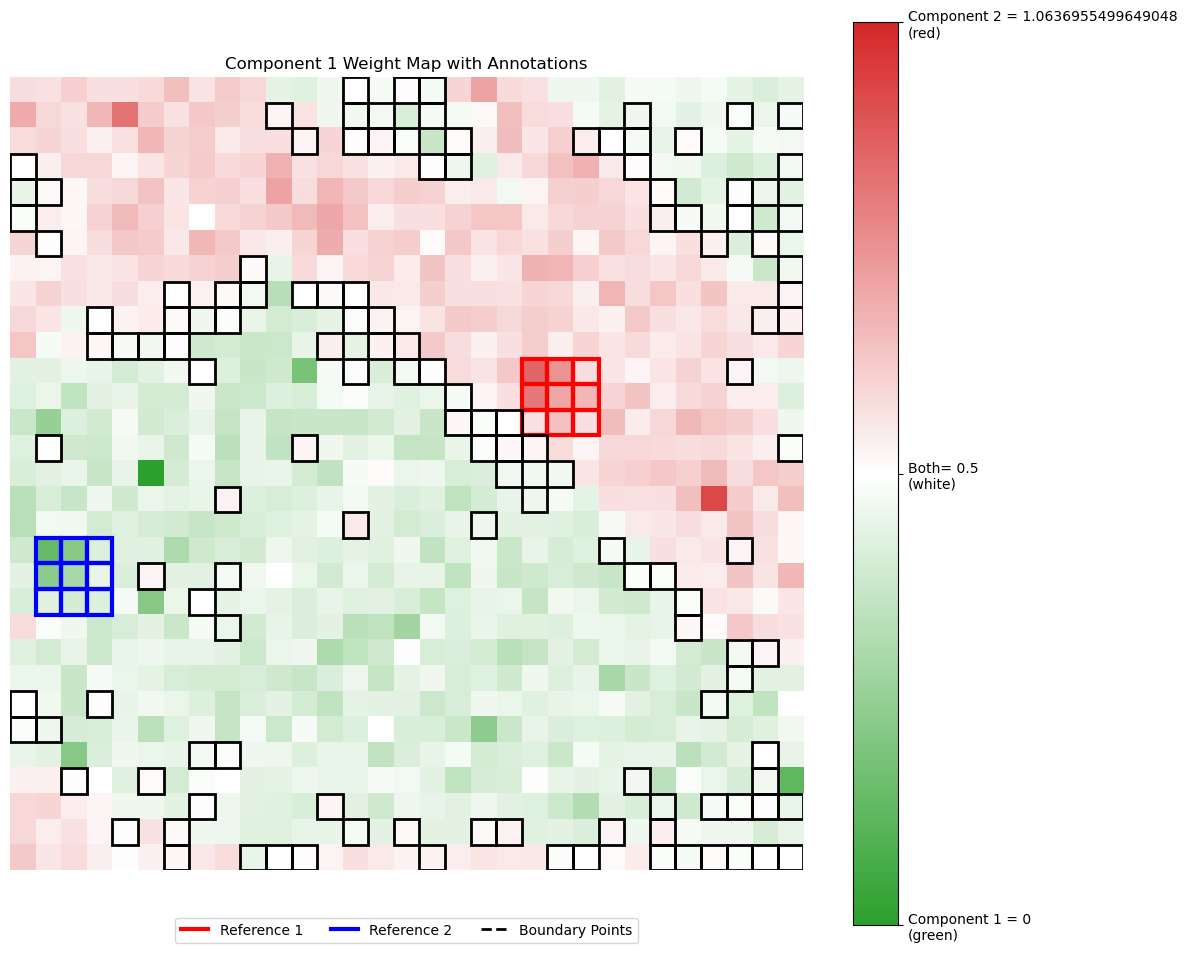

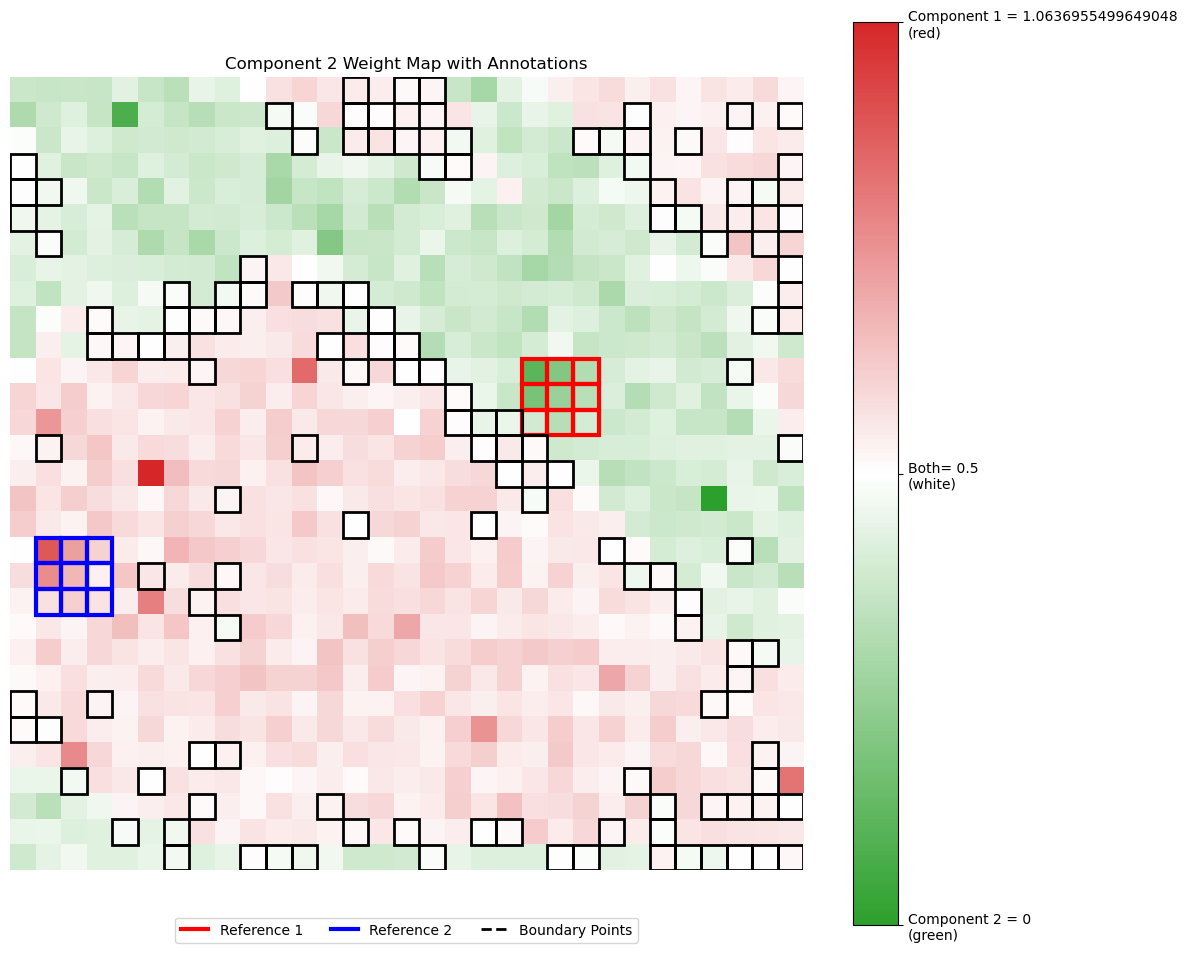

In [21]:
gmm_model4, cluster_coords_cnmf4, cluster_labels_cnmf4, optimal_n, silhouette = gmm_clustering(weights, loc_n, 2, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label_cnmf4 = {}
for label, coords_list in cluster_coords_cnmf4.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf4[coord_tuple] = label

boundary_mask2, boundary_scores2, boundary_locs2, boundary_labels2, slope, intercept = plot_cnmf_scatter_with_boundary(weights, loc_n, cluster_labels_cnmf4, optimal_n, ref9_pos, ref10_pos, anomalies_coord_label_dict3, d=0.04)

boundary_coord_label_dict2 = {}
for i in range(len(boundary_labels2)):
    coord = tuple(boundary_locs2[i])
    boundary_coord_label_dict2[coord] = boundary_labels2[i]
plot_cluster_heatmap(cluster_coords_cnmf4,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict, coord_to_label_cnmf4, name_map, cluster_name_map, True)

plot_weight_map_cnmf(weights, loc, None, ref9_pos, ref10_pos, 0, boundary_locs2)
plot_weight_map_cnmf(weights, loc, None, ref9_pos, ref10_pos, 1, boundary_locs2)

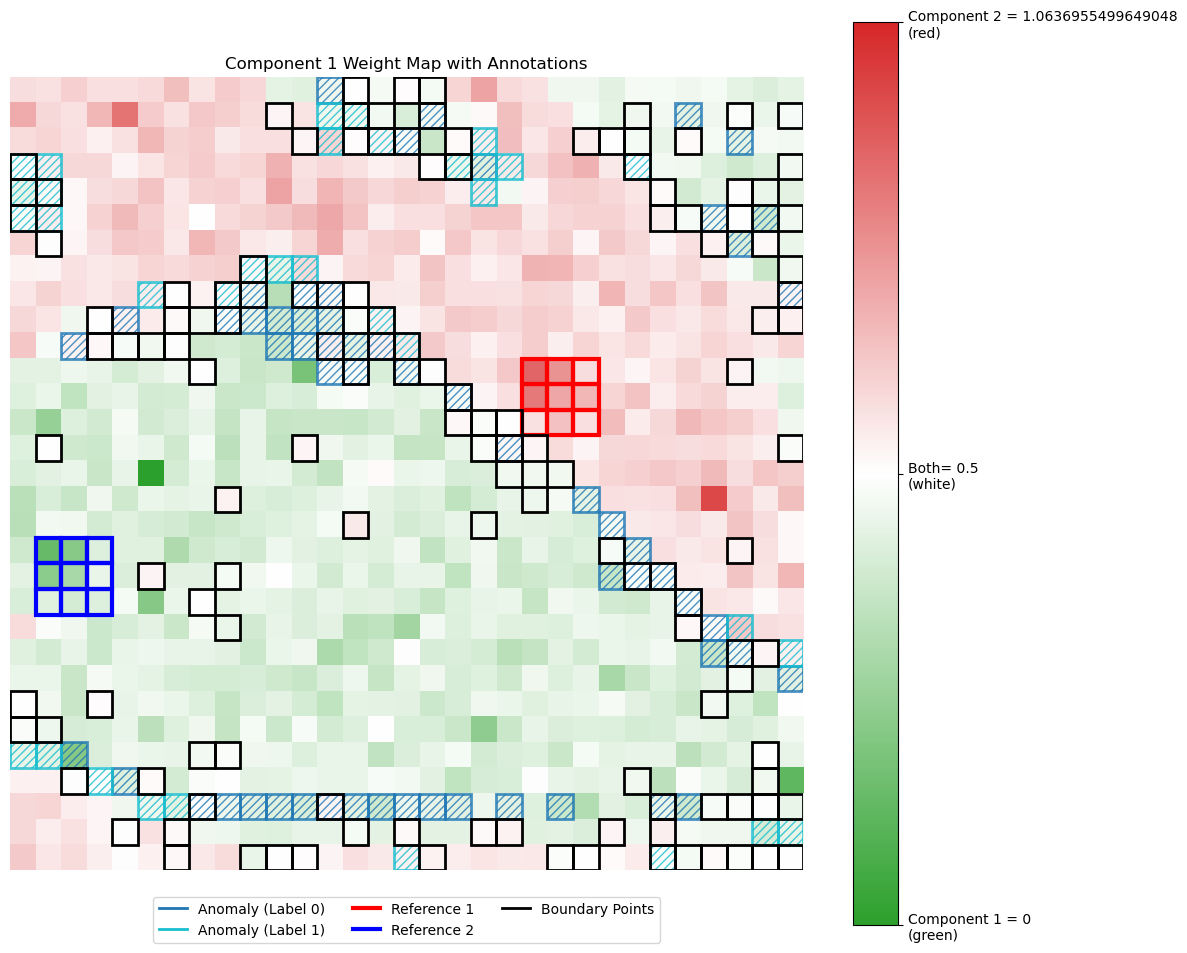

Similarity between anomalies and boundary points:
  Number of anomalies: 91
  Number of boundary points: 135
  Intersection: 33
  Jaccard Index: 0.1710
  Overlap Coefficient: 0.3626


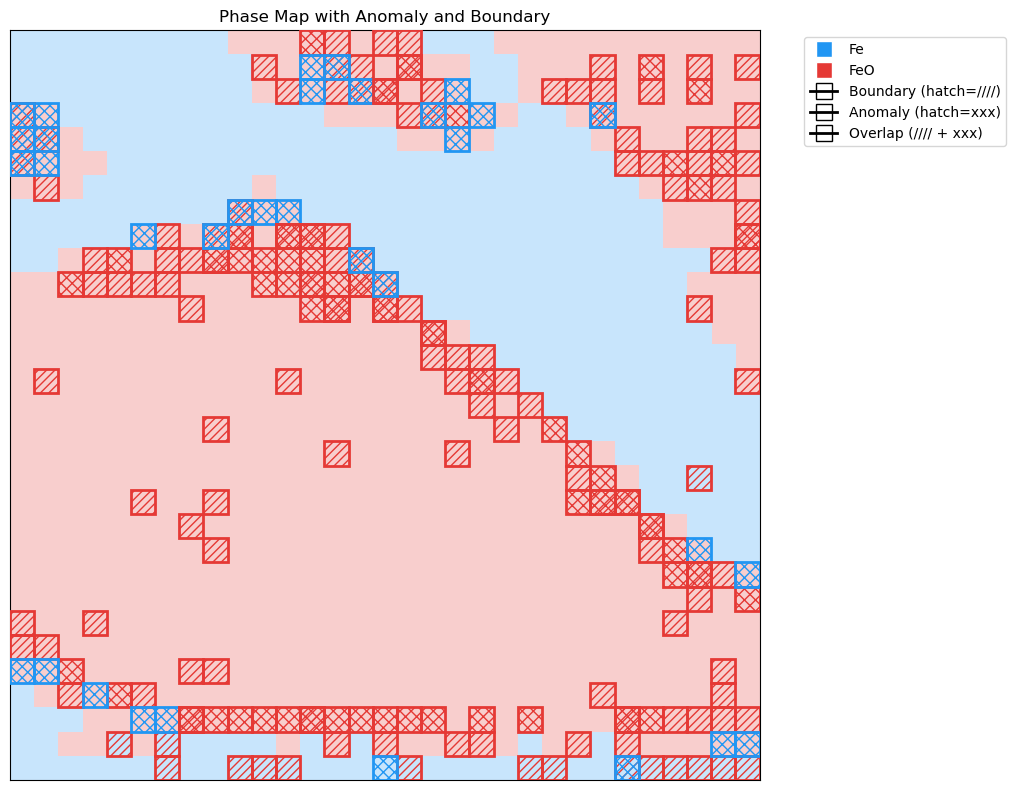

In [22]:
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights, loc_n, anomalies_coord_label_dict3, ref9_pos, ref10_pos, 0, boundary_coord_label_dict2)
coor_phase_map= {2: 'FeO', 3:'Fe'}
boundary_loc_label_map={0: 'FeO', 1:'Fe'}
anomalies_loc_label_map={0: 'FeO', 1:'Fe'}
plot_phase_heatmap(coor_dict, boundary_coord_label_dict2, anomalies_coord_label_dict3, coor_phase_map, boundary_loc_label_map, anomalies_loc_label_map, (31,31))

### 1.3 Correlations (Latent features/ weights/ pca scores/ X+Y-1/ Misorientation/ Mahalanobis)

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\quaternion\quaternion.py:497: UserWarning: Angles are quite high, did you forget to set degrees=True?
  warnings.warn("Angles are quite high, did you forget to set degrees=True?")
d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\process_indexing_data.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


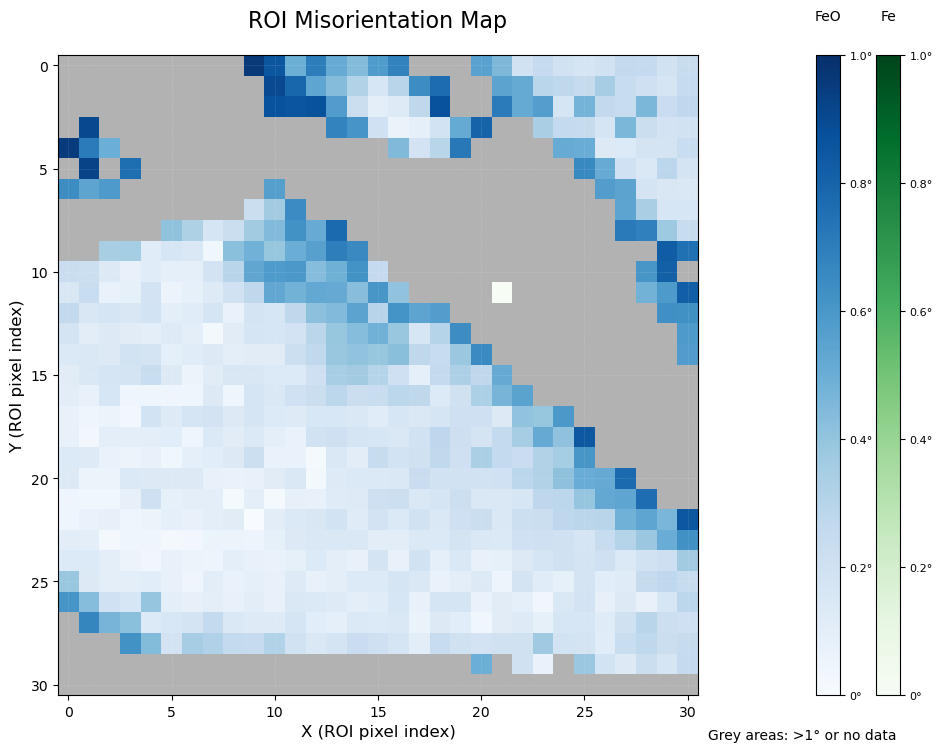

In [23]:
# misorientation calculated based on the orientation indexing (reference = window center)
roi_xrange=(20, 51)
roi_yrange=(5, 36)
phase_ref_points_relative={2: (9, 22), 3: (21, 11)}

result_table, mis_map, phase_map = compute_roi_misorientation_map_from_xmap(xmap, roi_xrange, roi_yrange, 0.05, phase_ref_points_relative, None)

In [24]:
# Mahalanobis/ EDS element
misorientation = pd.Series(result_table[:,3], name='Misorientation')
latent2   = pd.read_csv('../vae_representation/latents_output_2feature.csv',   header=None, skiprows=1)  # shape (961,2)
latent4   = pd.read_csv('../vae_representation/latents_output_4feature.csv',   header=None, skiprows=1)  # shape (961,4)
latent8   = pd.read_csv('../vae_representation/latents_output_8feature.csv',   header=None, skiprows=1)  # shape (961,8)
latent16  = pd.read_csv('../vae_representation/latents_output_16feature.csv',  header=None, skiprows=1)  # shape (961,16)
pca_scores= pd.read_csv('pca_scores1.csv',  header=None, skiprows=1)  # shape (961,10)
cnmf_w    = pd.read_csv('weight1.csv', header=None, skiprows=1) # shape (961,2)
cnmf_residual = cnmf_w[0] + cnmf_w[1] - 1

latent2.columns   = [f'L2_{i+1}'   for i in latent2.columns]
latent4.columns   = [f'L4_{i+1}'   for i in latent4.columns]
latent8.columns   = [f'L8_{i+1}'   for i in latent8.columns]
latent16.columns  = [f'L16_{i+1}'  for i in latent16.columns]
pca_scores.columns= [f'PC_{i+1}'   for i in pca_scores.columns]
cnmf_w.columns    = ['W1', 'W2']
cnmf_residual.name = 'W1+W2-1'


In [26]:
roi_eds = get_eds_average(roi_xrange, roi_yrange, s_edax, 'roi')
def normalize_roi_data_vectorized(roi_data):
    row_sums = np.nansum(roi_data, axis=1)

    row_sums[row_sums == 0] = 1
    
    normalized_data = roi_data / row_sums[:, np.newaxis]
    
    all_nan_rows = np.all(np.isnan(roi_data), axis=1)
    normalized_data[all_nan_rows] = 0
    
    return normalized_data
roi_eds = normalize_roi_data_vectorized(roi_eds)
roi_eds = pd.DataFrame(roi_eds, columns=['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe'])
ref_coord_window = {0:(29,27), 1:(41,16)}
m_distance = compute_mahalanobis_to_reference(pca_scores1, loc, cluster_labels2, ref_coord_window)
m_distance = pd.Series(m_distance, name='mahalanobis')

In [33]:
df_all = pd.concat([
    pca_scores, cnmf_w, cnmf_residual, misorientation, roi_eds, m_distance
], axis=1)

In [34]:
# Pearson correlation and spearman correlation
pearson_corr  = df_all.corr(method='pearson')
spearman_corr = df_all.corr(method='spearman')

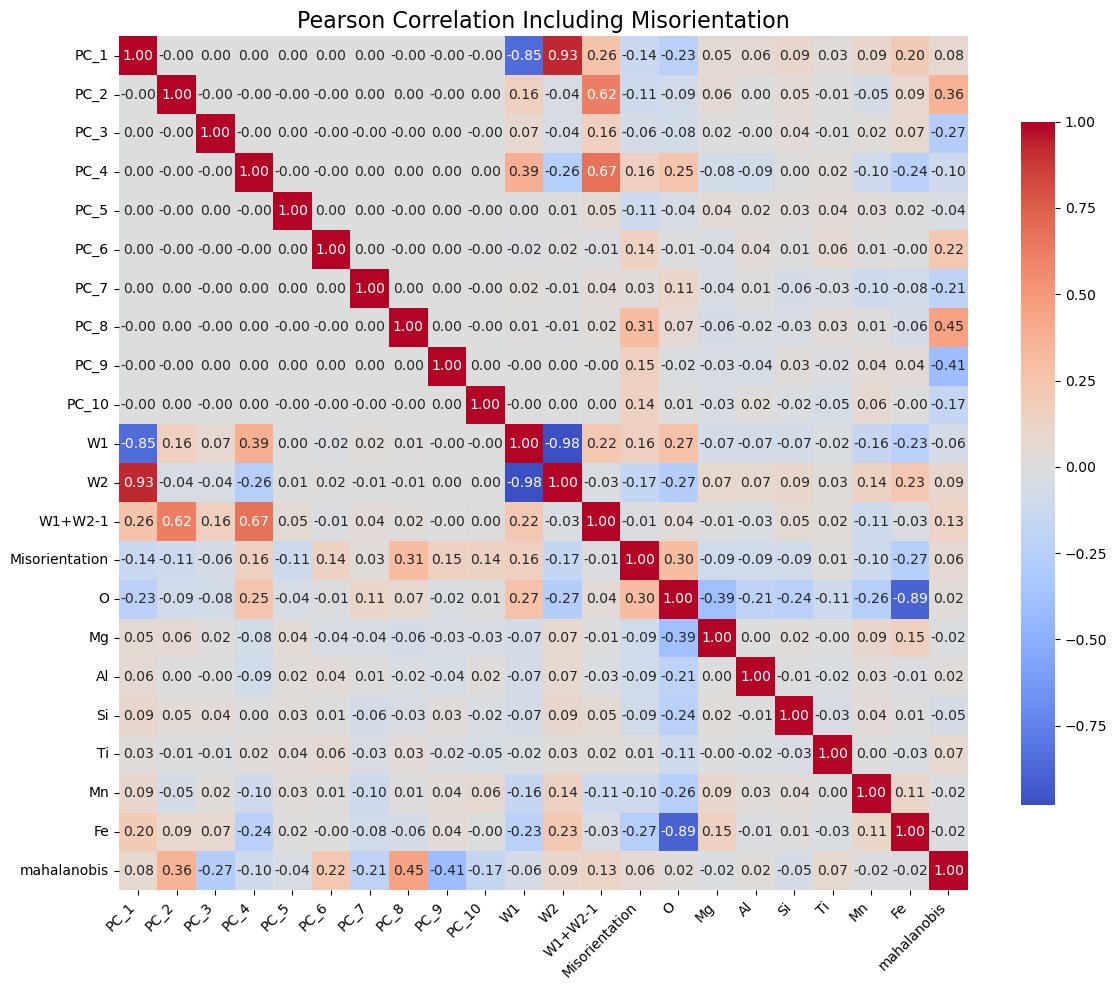

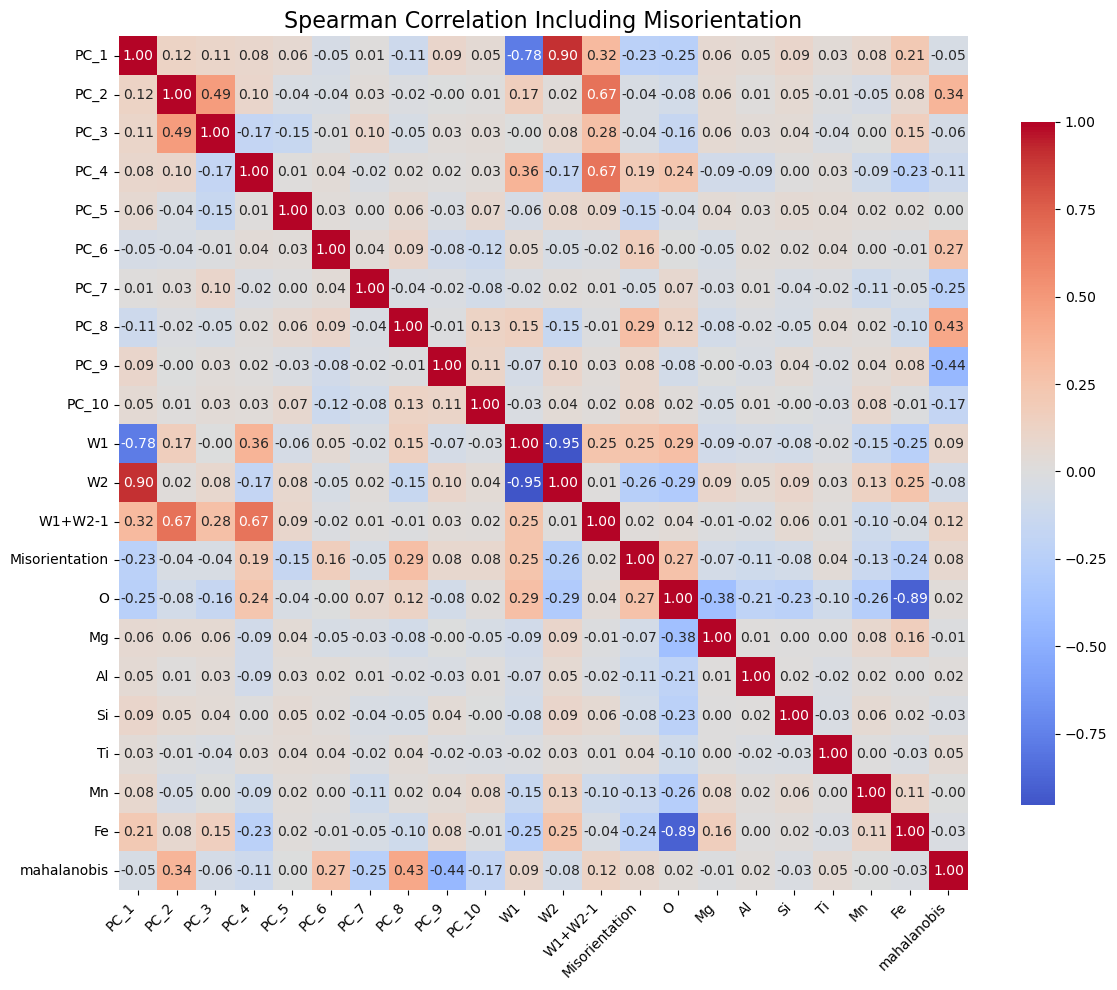

In [35]:
def plot_corr_heatmap(corr, title):
    plt.figure(figsize=(12,10))
    sns.heatmap(
        corr, annot=True, fmt='.2f',
        cmap='coolwarm', center=0,
        cbar_kws={'shrink':.8}
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(pearson_corr,  'Pearson Correlation Including Misorientation')
plot_corr_heatmap(spearman_corr, 'Spearman Correlation Including Misorientation')

In [36]:
print("Top positive Pearson correlations with Misorientation:")
print(
    pearson_corr['Misorientation']
    .drop('Misorientation')
    .sort_values(ascending=False)
    .head(5)
)
print("\nTop negative Pearson correlations with Misorientation:")
print(
    pearson_corr['Misorientation']
    .drop('Misorientation')
    .sort_values()
    .head(5)
)

Top positive Pearson correlations with Misorientation:
PC_8    0.306317
O       0.301030
PC_4    0.163937
W1      0.159401
PC_9    0.151924
Name: Misorientation, dtype: float64

Top negative Pearson correlations with Misorientation:
Fe     -0.267524
W2     -0.166491
PC_1   -0.143622
PC_2   -0.109446
PC_5   -0.108874
Name: Misorientation, dtype: float64


In [6]:
# 1. Extract the quaternions within ROI
step_size = 0.05
roi_coords, roi_quats = extract_roi_quaternions(
        xmap, roi_xrange, roi_yrange, step_size
    )

In [7]:
# 2. match data based on coordinates
matched_quats, matched_vars, matched_scores = match_data_by_coords(
        roi_coords, roi_quats, variations3, loc, pca_scores, step_size
    )

Matched 961 points out of 961 in ROI (100.00%)


In [8]:
# 3. Analyze the relations between quaternions and variations
quat_var_analysis = analyze_quaternion_variations_relationship(
    matched_quats, matched_vars
)

In [9]:
quat_var_analysis

{'correlations': [{'component': 0,
   'correlation': 0.12089762803726632,
   'p_value': 0.0001721438179072407},
  {'component': 1,
   'correlation': 0.021947955704847373,
   'p_value': 0.49676856335853165},
  {'component': 2,
   'correlation': -0.13236725659415127,
   'p_value': 3.8522206010516177e-05},
  {'component': 3,
   'correlation': -0.1634415659122364,
   'p_value': 3.4986976518255433e-07}],
 'canonical_correlation': 0.23691443388499953,
 'x_weights': array([[ 0.32845265],
        [ 0.71637035],
        [-0.60752078],
        [-0.09925161]]),
 'y_weights': array([[1.]]),
 'transformed_x': array([[ 0.37743655],
        [ 0.37410596],
        [-0.21240799],
        [-0.21788917],
        [-0.21488754],
        [-0.21728501],
        [-0.21682955],
        [-0.21526779],
        [-0.43118754],
        [ 0.94410933],
        [-0.21738007],
        [-0.22042341],
        [-0.22052122],
        [-0.22093261],
        [-0.22096582],
        [-0.22122584],
        [-0.2200937 ],
      

In [11]:
# 4. Analyze the scores and quaternions
quat_score_analysis = analyze_quaternion_scores_relationship(
    matched_quats, matched_scores, 4
)

In [12]:
quat_score_analysis

{'canonical_correlations': [0.8579778506319038,
  0.5107273376305157,
  0.36533658757623205,
  0.24643603058505542],
 'x_weights': array([[ 0.31185197,  0.04127061,  0.28104008,  0.90667611],
        [ 0.63811069,  0.72899488, -0.01793473, -0.24710231],
        [ 0.67378414, -0.67185604,  0.17255693, -0.25465369],
        [-0.20390691,  0.12438914,  0.94388502, -0.2281017 ]]),
 'y_weights': array([[ 0.88028794,  0.2823929 , -0.00260012, -0.024762  ],
        [-0.32322019,  0.50411682, -0.21326659, -0.01329847],
        [ 0.04933045, -0.17767351,  0.84582102, -0.0010053 ],
        [-0.18185705, -0.33825118,  0.03640337,  0.33013189],
        [-0.03127586, -0.03978645,  0.17624024, -0.10727096],
        [ 0.07577075, -0.23488242,  0.01798141, -0.39047319],
        [-0.17124698,  0.44070237,  0.18968542, -0.26280711],
        [-0.032022  ,  0.37635978,  0.27150469,  0.6970927 ],
        [-0.18859774, -0.02882679,  0.13256689, -0.22420123],
        [ 0.11170027, -0.35593508, -0.28128083,  

In [14]:
quat_score_analysis['transformed_y']

array([[-1.28085725,  3.01804717,  2.38013518, -1.78845016],
       [-0.40280859,  3.00480258,  2.38613278, -1.10366785],
       [ 0.40110465,  0.94260957,  0.94499669, -0.90111766],
       ...,
       [-0.71279227,  2.40303576, -3.63846757,  0.54178145],
       [-0.67226746,  2.58994136, -3.41735019,  0.58768759],
       [-0.61274512,  2.76487988, -3.24826868,  1.09393321]])

In [15]:
quat_score_analysis['transformed_x']

array([[-1.65873082,  1.20823511,  3.32039057, -1.62308163],
       [-1.65499132,  1.20319534,  3.31698273, -1.61538412],
       [ 0.82260916, -0.04320111,  0.08786677, -0.44195487],
       ...,
       [-0.03636475,  0.35603375, -2.27059754,  0.20061767],
       [-0.03941557,  0.35672561, -2.27284242,  0.19376563],
       [-0.04031136,  0.355698  , -2.27434774,  0.19268904]])